<a href="https://colab.research.google.com/github/jaynarayan94/Project-Predict-Material-Type-And-Ratings/blob/master/Predict_Material_Type_Final_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [102]:
import pandas as pd
import numpy as np
import string
import nltk
import re
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,SnowballStemmer 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline, FeatureUnion
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.base import BaseEstimator, TransformerMixin

from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Run the below piece of code for the first time
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [20]:
# Standard plotly imports
import chart_studio.plotly as py
import plotly.graph_objects as go
from plotly.offline import iplot, init_notebook_mode

# Using plotly + cufflinks in offline mode
# import cufflinks
# cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

# Load dataset

In [2]:
from google.colab import files

uploaded1 = files.upload()

Saving train_file.csv to train_file.csv


In [65]:
import io
df = pd.read_csv(io.StringIO(uploaded1['train_file.csv'].decode('utf-8')))

df.head()

,ID,UsageClass,CheckoutType,CheckoutYear,CheckoutMonth,Checkouts,Title,Creator,Subjects,Publisher,PublicationYear,MaterialType
0,1,Physical,Horizon,2005,4,1,Tidal wave,NaN,"Tsunamis, Tsunamis Juvenile literature",NaN,NaN,BOOK
1,2,Physical,Horizon,2005,4,1,London holiday / Richard Peck.,"Peck, Richard, 1934-",NaN,"Viking,",1998.,BOOK
2,3,Physical,Horizon,2005,4,3,Cinco de Mayo : celebrating Hispanic pride / C...,"Gnojewski, Carol",Cinco de Mayo Mexican holiday History Juvenile...,"Enslow Publishers,",c2002.,BOOK
3,4,Physical,Horizon,2005,4,1,Annapolis,NaN,"War stories, Historical fiction, Domestic fict...",NaN,NaN,BOOK
4,5,Physical,Horizon,2005,4,1,As a man thinketh,NaN,Thought and thinking,NaN,NaN,BOOK


In [7]:
from google.colab import files

uploaded2 = files.upload()

Saving test_file.csv to test_file.csv


In [66]:
import io
df_test = pd.read_csv(io.StringIO(uploaded2['test_file.csv'].decode('utf-8')))

df_test.head()

,ID,UsageClass,CheckoutType,CheckoutYear,CheckoutMonth,Checkouts,Title,Creator,Subjects,Publisher,PublicationYear
0,31654,Physical,Horizon,2005,4,1,Footprints at the window,NaN,"England Fiction, Space and time Fiction",NaN,NaN
1,31655,Physical,Horizon,2005,4,2,Seven brides for seven brothers,NaN,"Video recordings for the hearing impaired, Mus...",NaN,NaN
2,31656,Physical,Horizon,2005,4,2,History [sound recording] / Loudon Wainwright ...,"Wainwright, Loudon, III, 1946-",Popular music 1991 2000,"Charisma,",p1992.
3,31657,Physical,Horizon,2005,4,2,Doing big business on the internet,NaN,"Internet, Internet advertising, Information ne...",NaN,NaN
4,31658,Physical,Horizon,2005,4,2,Lets learn how to dance shag,NaN,"Shag Dance, Ballroom dancing",NaN,NaN


In [70]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# !unzip -q "/content/gdrive/My Drive/Datasets/Predict_Material_Type_&_Rating/data.zip"

# df = pd.read_csv("train_file.csv")
# df_test = pd.read_csv("test_file.csv")

print('Training Set dimension :',df.shape,'\n\nTest Set dimension :', df_test.shape)

Training Set dimension : (31653, 12) 

Test Set dimension : (21102, 11)


# Lets understand the data

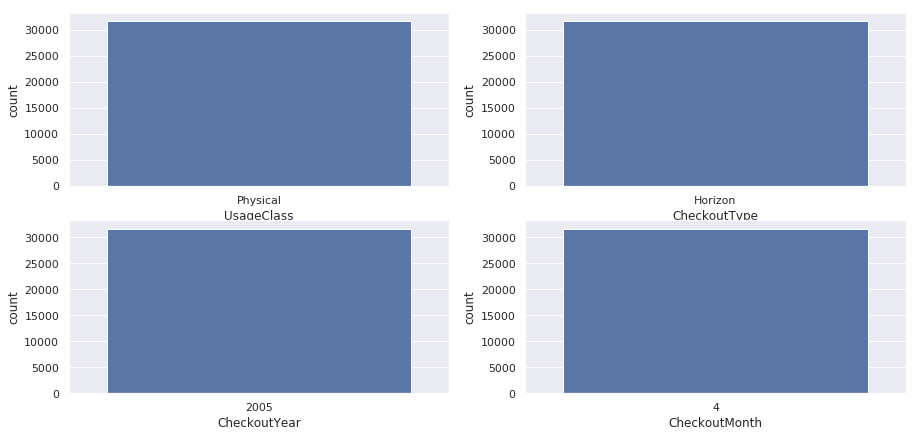

In [76]:
sns.set()
plt.figure(figsize=(15,7))
plt.subplot(2,2,1)
sns.countplot(x='UsageClass', data=df)

plt.subplot(2,2,2)
sns.countplot(x='CheckoutType', data=df)

plt.subplot(2,2,3)
sns.countplot(x='CheckoutYear', data=df)

plt.subplot(2,2,4)
sns.countplot(x='CheckoutMonth', data=df)
plt.show()

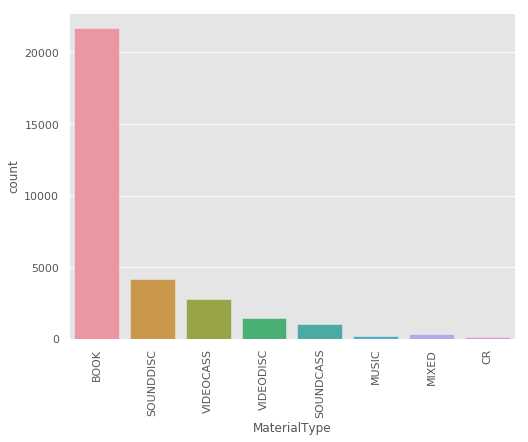

Counter({'BOOK': 21707,
         'CR': 94,
         'MIXED': 347,
         'MUSIC': 165,
         'SOUNDCASS': 1020,
         'SOUNDDISC': 4149,
         'VIDEOCASS': 2751,
         'VIDEODISC': 1420})

In [77]:
plt.style.use('ggplot')
plt.figure(figsize=(8,6))
sns.countplot(df['MaterialType'])
plt.xticks(rotation =90)
plt.show()

Counter(df['MaterialType'])

## Categorical_Feature_Distribution

In [0]:
def categorical_feature_distribution(feature_name, target_name, top_counts=None):
    material_trace = []

    for material in df[target_name].unique():
        if not top_counts:
            _tmp_material = df[df[target_name]==material][feature_name].value_counts()
        else:
            _tmp_material = df[df[target_name]==material][feature_name].value_counts()[:top_counts]
            
        tmp_trace = go.Bar(
            x=_tmp_material.index,
            y=_tmp_material.values,
            name=material
        )
        material_trace.append(tmp_trace)

    layout = go.Layout(
        barmode='group',
        title=feature_name + " VS " + target_name + " - Distribution ",
        yaxis=dict(
            title='Counts',
        ),
        xaxis=dict(
            title=feature_name,
        )       
    )

    fig = go.Figure(data=material_trace, layout=layout)
    iplot(fig) #, filename='grouped-bar')    

In [34]:
df['MaterialType'].iplot(kind='hist', xTitle='MaterialType',
                  yTitle='count', title='Target Distribution')

AttributeError: ignored

In [0]:
categorical_feature_distribution('Checkouts','MaterialType')

In [0]:
categorical_feature_distribution('Creator','MaterialType', 20)

In [0]:
categorical_feature_distribution('Publisher','MaterialType', 20)

In [0]:
categorical_feature_distribution('Subjects','MaterialType', 20)

## WordCloud

In [0]:
def create_wordcloud(material):
    text = " ".join(review for review in df[df['MaterialType'] == material].Title)
    print ("There are {} words in the combination of all review.".format(len(text)))

    # Create the wordcloud object
    wordcloud = WordCloud(width=1024,
                          height=480, 
                          margin=0).generate(text)

    # Display the generated image:
    plt.figure(figsize=(15,7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

There are 1095796 words in the combination of all review.


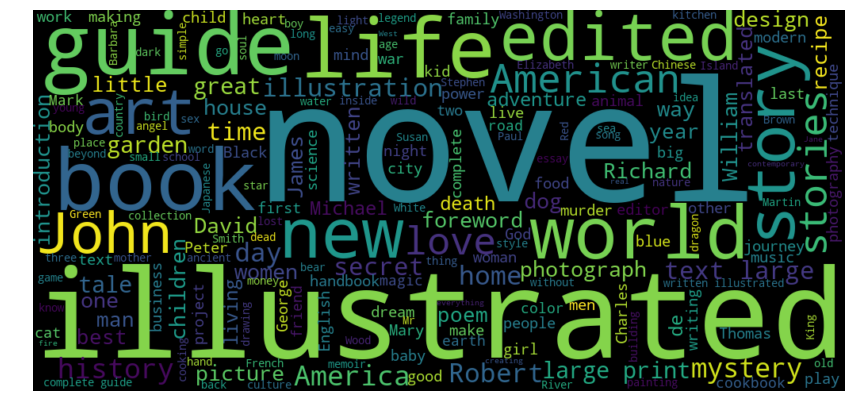

In [46]:
create_wordcloud('BOOK')

There are 138709 words in the combination of all review.


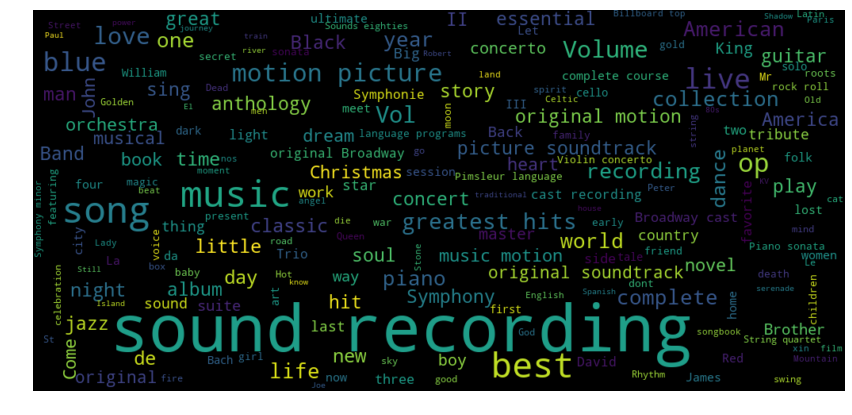

In [47]:
create_wordcloud('SOUNDDISC')

There are 99976 words in the combination of all review.


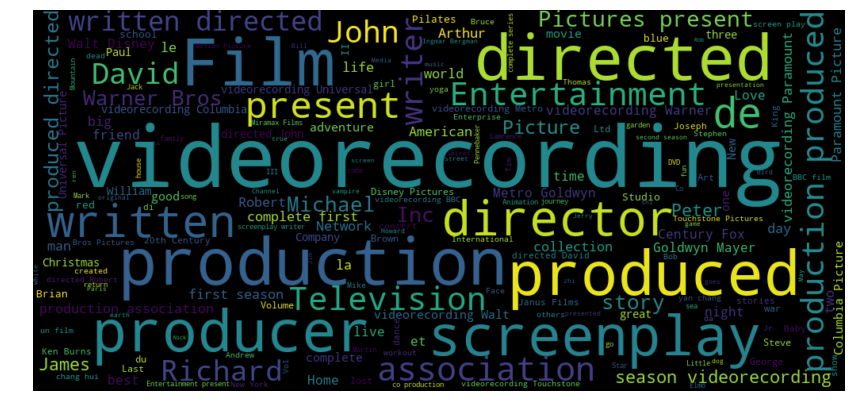

In [48]:
create_wordcloud('VIDEODISC');

## Checking and Imputing the missing values

In [78]:
# Checking for Missing Value in the Training Set

na_train =df.isnull().sum()
pd.DataFrame({'Count':na_train,'Percentage':(na_train/len(df))*100})

,Count,Percentage
ID,0,0.000000
UsageClass,0,0.000000
CheckoutType,0,0.000000
CheckoutYear,0,0.000000
CheckoutMonth,0,0.000000
Checkouts,0,0.000000
Title,0,0.000000
Creator,23137,73.095757
Subjects,1763,5.569772
Publisher,21916,69.238303


In [79]:
# Checking for Missing Value in the test Set

na_test =df_test.isnull().sum()
pd.DataFrame({'Count':na_test,'Percentage':(na_test/len(df_test))*100})

,Count,Percentage
ID,0,0.000000
UsageClass,0,0.000000
CheckoutType,0,0.000000
CheckoutYear,0,0.000000
CheckoutMonth,0,0.000000
Checkouts,0,0.000000
Title,0,0.000000
Creator,15104,71.576154
Subjects,1213,5.748270
Publisher,14227,67.420150


In [0]:
df['Publisher'].fillna("nopublisher", inplace=True)
df_test['Publisher'].fillna("nopublisher", inplace=True)

df['Creator'].fillna("nocreator", inplace=True)
df_test['Creator'].fillna("nocreator", inplace=True)

df['Subjects'].fillna("nosubject", inplace=True)
df_test['Subjects'].fillna("nosubject", inplace=True)

# PIPELINE 
* End to End Model Workflow

![Pipeline](https://github.com/jaynarayan94/Project-Predict-Material-Type-Ratings/blob/master/PIPELINE.jpg?raw=true)

## Create new feature "INFO"  by concatenating Title, Subjects , Publisher, Creator

In [0]:
df['AllInfo'] = df['Title'] + " " + df['Creator'] + " " + df['Subjects'] + " " + df['Publisher']
df_test['AllInfo'] = df_test['Title'] + " " + df_test['Creator'] + " " + df_test['Subjects'] + " " + df_test['Publisher']

> **Numerical encode categorical features**

In [119]:
target_encoder = LabelEncoder()
y = target_encoder.fit_transform(df['MaterialType'])

categorical_features = ['Checkouts', 'Creator', 'Subjects', 'Publisher']

for col in categorical_features:
    print(col)
    le = LabelEncoder()
    le.fit(list(df[col]) + list(df_test[col]))
    df[col] = le.transform(df[col])
    df_test[col] = le.transform(df_test[col])

Checkouts
Creator
Subjects
Publisher


In [120]:
df.head()

,ID,UsageClass,CheckoutType,CheckoutYear,CheckoutMonth,Checkouts,Title,Creator,Subjects,Publisher,PublicationYear,MaterialType,AllInfo
0,1,Physical,Horizon,2005,4,0,Tidal wave,10462,35812,5028,NaN,BOOK,"Tidal wave nocreator Tsunamis, Tsunamis Juveni..."
1,2,Physical,Horizon,2005,4,0,London holiday / Richard Peck.,7232,39836,4652,1998.,BOOK,"London holiday / Richard Peck. Peck, Richard, ..."
2,3,Physical,Horizon,2005,4,2,Cinco de Mayo : celebrating Hispanic pride / C...,3444,6872,1486,c2002.,BOOK,Cinco de Mayo : celebrating Hispanic pride / C...
3,4,Physical,Horizon,2005,4,0,Annapolis,10462,38179,5028,NaN,BOOK,"Annapolis nocreator War stories, Historical fi..."
4,5,Physical,Horizon,2005,4,0,As a man thinketh,10462,35296,5028,NaN,BOOK,As a man thinketh nocreator Thought and thinki...


> **Add some functions and Transformer class**

In [0]:
# def tokenize(text):
#     '''
#         Input: text
#         Returns: clean tokens
#         Desc:
#             Generates a clean token of text (words) by first getting words from the text.
#             Applies Lemmatization on the words.
#             Normalize the text by lowering it and removes the extra spaces.
#     '''
#     tokens = word_tokenize(text)
#     lemmatizer = WordNetLemmatizer()

#     clean_tokens = []
#     for tok in tokens:
#         #
#         if tok not in string.punctuation:# and tok not in stop_words:
#             clean_tok = tok.lower().strip()
#             #clean_tok = lemmatizer.lemmatize(tok).lower().strip()
#             clean_tokens.append(clean_tok)

#     return clean_tokens

In [0]:
stop_words = set(stopwords.words('english'))

def tokenize(text):
  clean_tokens = []

  for i in range(len(text)):
    clean_tok = re.sub(r'[^a-zA-Z]', ' ',text[i])

    # review = [word for word in review if word not in string.punctuation]
    Wlm = WordNetLemmatizer()

    clean_tok = [Wlm.lemmatize(word).strip() for word in clean_tok.split() if word.lower() not in [stopwords.words('english') , string.punctuation]]

    clean_tok = ' '.join(clean_tok)

    clean_tokens.append(clean_tok)

  return clean_tokens

In [0]:
tokenize(df_test['AllInfo'])[:10]

In [0]:
class TextLengthExtractor(BaseEstimator, TransformerMixin):
    '''
        Input: X
        return: pandas series of length of text
        TextLengthExtractor is a transformer , can be used in pipeline to extract the length of the text from a given input.
        Input can be an array of text or pandas Series.
    '''
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.Series(X).apply(lambda x: len(x)).values.reshape(-1,1)
    
class WordCountExtractor(BaseEstimator, TransformerMixin):
    '''
        Input: X
        return: pandas series of word count
        WordCountExtractor is a transformer , can be used in pipeline to extract the number of words of the text from a given input.
        Input can be an array of text or pandas Series.
    '''
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.Series(X).apply(lambda x: len(x.split())).values.reshape(-1,1)
        
class MessageExtractor(BaseEstimator, TransformerMixin):        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X["AllInfo"]
    
class FeatureSelector( BaseEstimator, TransformerMixin ):
    #Class Constructor     
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        return X[ [ 'Checkouts','Creator','Publisher','Subjects'] ] 

# Pipeline for Feature Engineering

In [0]:
pipeline = Pipeline([
        ('features', FeatureUnion([

            ('text_pipeline', Pipeline([
                ('text', MessageExtractor()),
                ('tfidf', TfidfVectorizer(tokenizer=tokenize,
                                         ngram_range=(1,2),
                                         max_df=0.5,
                                         max_features=5000,
                                         use_idf=False)),
            ])),
            
            ('categorical_features', Pipeline([
                ('cat_features', FeatureSelector()),
                
            ])),
            
            ('text_length_pipeline', Pipeline([
                ('text', MessageExtractor()),
                ('text_len', TextLengthExtractor()),
                
            ])),

            ('word_count_pipeline', Pipeline([
                ('text', MessageExtractor()),
                ('word_count', WordCountExtractor()),                
            ])),

        ])),
        
]) 

In [157]:
pipeline.fit(df)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('text_pipeline',
                                                 Pipeline(memory=None,
                                                          steps=[('text',
                                                                  MessageExtractor()),
                                                                 ('tfidf',
                                                                  TfidfVectorizer(analyzer='word',
                                                                                  binary=False,
                                                                                  decode_error='strict',
                                                                                  dtype=<class 'numpy.float64'>,
                                                                                  encoding='utf-8',
                    

In [0]:
XTest_trans = pipeline.transform(df_test)
dxtest = xgb.DMatrix(XTest_trans)

In [162]:
XTest_trans.todense()

matrix([[0.00000000e+00, 0.00000000e+00, 1.58113883e-01, ...,
         1.10070000e+04, 8.60000000e+01, 1.20000000e+01],
        [2.42535625e-01, 0.00000000e+00, 0.00000000e+00, ...,
         3.75820000e+04, 1.10000000e+02, 1.50000000e+01],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         2.82850000e+04, 1.15000000e+02, 1.60000000e+01],
        ...,
        [0.00000000e+00, 0.00000000e+00, 2.02259959e-01, ...,
         2.20420000e+04, 1.94000000e+02, 2.60000000e+01],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.69750000e+04, 9.60000000e+01, 1.20000000e+01],
        [3.73001923e-01, 0.00000000e+00, 0.00000000e+00, ...,
         8.51600000e+03, 1.10000000e+02, 1.60000000e+01]])

# XGB parameters

## OOF = Out Of fold (predictions)

![OOF](https://github.com/jaynarayan94/Project-Predict-Material-Type-Ratings/blob/master/StratifiedKFold_CV.png?raw=true)

In [0]:
param = {'objective':'multi:softprob', # use softmax multi-class classification
         'eta' : 0.1,
         'max_depth' : 6,
         'silent': 1,
         'nthread' : 4,
         'num_class' : 8,
         'eval_metric' : ['mlogloss'],
         'seed' : 1
         }

skf = StratifiedKFold(n_splits= 5, random_state=1, shuffle=True)

In [0]:
y_test_pred = np.zeros((df_test.shape[0], 8))
print(y_test_pred.shape)
y_valid_scores = []

X = df
fold_cnt = 1
for train_index, test_index in skf.split(X, y):
    print("FOLD .... ",fold_cnt)
    fold_cnt += 1
    
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    
    X_train_trans = pipeline.transform(X_train)
    dtrain = xgb.DMatrix(X_train_trans, label=y_train)

    X_valid_trans = pipeline.transform(X_valid)
    dvalid = xgb.DMatrix(X_valid_trans, label=y_valid)
    
    evallist = [(dtrain, 'train'), (dvalid, 'eval')]
    
    num_round = 10000
    bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10, verbose_eval=50)
    
    #Predict validation data
    y_pred_valid = bst.predict(dvalid, ntree_limit=bst.best_ntree_limit)
    y_valid_scores.append(f1_score(y_valid, np.argmax(y_pred_valid, axis=1), average='weighted'))
    
    #Predict test data
    y_pred = bst.predict(dxtest, ntree_limit=bst.best_ntree_limit)
    
    y_test_pred += y_pred

In [0]:
y_test_pred /= num_splits

In [0]:
y_valid_scores

[0.8814103373715003,
 0.8878344997333046,
 0.8835592353761934,
 0.8775448550875664,
 0.8809004460551831]

In [0]:
np.mean(y_valid_scores)

0.8822498747247497

# Prepare the output

In [0]:
pred_material = np.argmax(y_test_pred, axis=1)
output = df_test[['ID']].copy()
output['MaterialType'] = target_encoder.inverse_transform(pred_material)

In [0]:
output.head()

,ID,MaterialType
0,31654,BOOK
1,31655,VIDEOCASS
2,31656,SOUNDDISC
3,31657,BOOK
4,31658,VIDEOCASS


In [0]:
output.to_csv("./predict_material_submission.csv", index=False)